<a href="https://colab.research.google.com/github/n8mcdunna/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Nathan_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv', parse_dates= ['SALE DATE'], index_col= 'SALE DATE')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [5]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
# Subsetting the dataframe
condition1 = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'
condition2 = df['SALE_PRICE'] > 100000
condition3 = df['SALE_PRICE'] < 2000000
df = df[condition1 & condition2 & condition3]

In [7]:
print(df.shape)
df.isnull().sum()

(3151, 20)


BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
dtype: int64

In [8]:
# Removing useless columns filled with NaNs
df.dropna(axis= 1, inplace= True)
print(df.shape)
df.isnull().sum()

(3151, 18)


BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
dtype: int64

In [9]:
# Find categorical variables
df.select_dtypes('object').nunique()

BOROUGH                              5
NEIGHBORHOOD                         7
BUILDING_CLASS_CATEGORY              1
TAX_CLASS_AT_PRESENT                 2
BUILDING_CLASS_AT_PRESENT           13
ADDRESS                           3135
LAND_SQUARE_FEET                  1035
BUILDING_CLASS_AT_TIME_OF_SALE      11
dtype: int64

In [10]:
# Drop high cardinality columns
hc_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 12]
df.drop(hc_cols, inplace= True, axis = 1)

In [11]:
# Train/test split
target = 'SALE_PRICE'
y = df[target]
X = df.drop(columns= target)

cutoff = '2019-04-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [12]:
# One hot encoding categorical variables
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(use_cat_names= True)

XT_train = ohe.fit_transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [13]:
print(XT_train.shape)
print(XT_test.shape)
print(y_train.shape)
print(y_test.shape)

(2507, 35)
(644, 35)
(2507,)
(644,)


In [14]:
XT_train.columns

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_EAST NEW YORK', 'NEIGHBORHOOD_BEDFORD STUYVESANT',
       'NEIGHBORHOOD_FOREST HILLS', 'NEIGHBORHOOD_BOROUGH PARK',
       'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_A

In [15]:
# Feature selection with selectkbest
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(k= 15)
XT_train_selected = selector.fit_transform(XT_train, y_train)
XT_test_selected = selector.transform(XT_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 23 34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [16]:
print(XT_train_selected.shape)
print(XT_test_selected.shape)

(2507, 15)
(644, 15)


In [17]:
selected_mask = selector.get_support()
selected_names = XT_train.columns[selected_mask]
[print(name) for name in selected_names];

BOROUGH_1
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0


In [18]:
# Modeling using linear and ridge regression
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

LR_model = LinearRegression()
LR_model.fit(XT_train_selected, y_train)

ridge_model = Ridge(alpha = 5, normalize= False)
ridge_model.fit(XT_train_selected, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [19]:
print('Linear Reg training MAE: ', mean_absolute_error(y_train, LR_model.predict(XT_train_selected)))
print('Linear Reg testing MAE:  ', mean_absolute_error(y_test, LR_model.predict(XT_test_selected)))
print('Ridge training MAE:      ', mean_absolute_error(y_train, ridge_model.predict(XT_train_selected)))
print('Ridge testing MAE:       ', mean_absolute_error(y_test, ridge_model.predict(XT_test_selected)))
print('Ridge R^2:               ', r2_score(y_train, ridge_model.predict(XT_train_selected)))
print('Ridge R^2:               ', r2_score(y_test, ridge_model.predict(XT_test_selected)))

Linear Reg training MAE:  184869.17704018418
Linear Reg testing MAE:   177830.6255464506
Ridge training MAE:       185866.5700274186
Ridge testing MAE:        179261.42391738287
Ridge R^2:                0.2575745046367698
Ridge R^2:                0.27423297693396564


In [20]:
X_train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
SALE DATE,,,,,,,,,,,,,,
2019-01-01,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
2019-01-01,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
2019-01-02,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
2019-01-02,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1,A2
2019-03-29,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,A5
2019-03-29,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,A1


In [52]:
maes = []
Rsquareds = []

for k in range(1, len(XT_train.columns)+1):

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(XT_train, y_train)
    X_test_selected = selector.transform(XT_test)

    #model = LinearRegression()
    model = Ridge(alpha = 5, normalize= False)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    Rsquare = r2_score(y_test, y_pred)

    maes.append(mae)
    Rsquareds.append(Rsquare)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

157412.81154886482


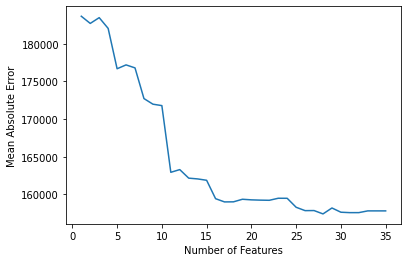

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(1, len(maes)+1)
y = maes
print(min(maes))

plt.plot(x, y)
plt.xlabel('Number of Features')
plt.ylabel('Mean Absolute Error')
plt.show();

0.39767924351789397


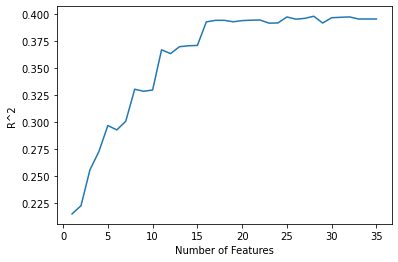

In [54]:
print(max(Rsquareds))

y = Rsquareds

plt.plot(x, y)
plt.xlabel('Number of Features')
plt.ylabel('R^2')
plt.show();

In [ ]:
157492.24827086728 for Linear Regression